In [1]:
%matplotlib notebook
import numpy as np
import foggie
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.foggie_load import *
from foggie.utils import yt_fields 
#from foggie.satellites.for_paper.central_projection_plots import make_projection_plots
import argparse
from foggie.utils.consistency import *
from numpy import *
from scipy.spatial import geometric_slerp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from yt.units import kpc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
def accept(event):
    if event.key == "enter":
        print("Selected points:")
        print(selector.xys[selector.ind])
        selector.disconnect()
        ax.set_title("")
        fig.canvas.draw()


mass_types = [(0., 1.5e4, 'cold', 'darkblue'),
             (1.5e4, 1.e5, 'warm', 'blue'),
             (1.e5, 1.e6, 'warmhot', 'red'),
             (1.e6, 1.e10, 'hot', 'darkred'), 
             (-1., -1., 'stars', 'goldenrod'),
             (-1., -1., 'dm', 'black')]


class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()



def parse_args(arg_str):
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter,
                                     description='''identify satellites in FOGGIE simulations''')
    parser.add_argument('-system', '--system', metavar='system', type=str, action='store', \
                        help='Which system are you on? Default is Jase')
    parser.set_defaults(system="saje")

    parser.add_argument('-simname', '--simname', default=None, help='Simulation to be analyzed.')

    parser.add_argument('-simdir', '--simdir', default='/nobackupp2/mpeeples', help='simulation output directory')

    parser.add_argument('-haloname', '--haloname', default='halo_008508', help='halo_name')

    parser.add_argument('--run', metavar='run', type=str, action='store',
                        help='which run? default is natural')
    parser.set_defaults(run="nref11c_nref9f")

    parser.add_argument('--halo', metavar='halo', type=str, action='store',
                        help='which halo? default is 8508 (Tempest)')
    parser.set_defaults(halo="8508")

    parser.add_argument('--pwd', dest='pwd', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(pwd=False)

    parser.add_argument('--output', metavar='output', type=str, action='store',
                        help='which output? default is RD0020')
    parser.set_defaults(output="RD0027")


    parser.add_argument('--save_dir', metavar='save_dir', type=str, action='store',
                        help='directory to save products')
    parser.set_defaults(save_dir="~")

    parser.add_argument('--use_halo_c_v', dest='use_halo_c_v', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(use_halo_c_v=True)

    args = parser.parse_args("")
    return args

mass_types = [(0., 1.5e4, 'cold', 'darkblue'),
             (1.5e4, 1.e5, 'warm', 'blue'),
             (1.e5, 1.e6, 'warmhot', 'red'),
             (1.e6, 1.e10, 'hot', 'darkred'), 
             (-1., -1., 'stars', 'goldenrod'),
             (-1., -1., 'dm', 'black')]

def phi_angular_momentum(field, data):
    if ('dm' in field.name[0]) | ('stars' in field.name[0]): name = 'particle_angular_momentum'
    else:  name = 'angular_momentum'
    Lx = data['%s_x'%name]
    Ly = data['%s_y'%name]
    Lz = data['%s_z'%name]
    L_tot = np.sqrt(Lx**2. + Ly**2. + Lz**2.)
    phi_L = np.arccos(Lz/L_tot)*180./pi
    return phi_L

def theta_angular_momentum(field, data):
    if ('dm' in field.name[0]) | ('stars' in field.name[0]): name = 'particle_angular_momentum'
    else:  name = 'angular_momentum'

    Lx = data['%s_x'%name]
    Ly = data['%s_y'%name]

    theta_L   = np.arctan2(Ly, Lx)*180./pi    
    return theta_L



In [2]:
args = parse_args("")

if False:
    args.halo = 'ck'
    args.output = 'DD0054'
    
if args.halo == 'ck':
        ds = yt.load('/Users/rsimons/Dropbox/foggie/sims/idealized_CK/%s/%s'%(args.output, args.output))
        cen = [0.5, 0.5, 0.5]
else:
    ds, refine_box = load_sim(args)
    cen = ds.halo_center_kpc

    
ds.add_field(('gas', 'phi_L'), phi_angular_momentum, sampling_type = 'cell')
ds.add_field(('gas', 'theta_L'), theta_angular_momentum, sampling_type = 'cell')
ds.add_field(('dm', 'phi_L'), phi_angular_momentum, sampling_type = 'particle')
ds.add_field(('dm', 'theta_L'), theta_angular_momentum, sampling_type = 'particle')
ds.add_field(('stars', 'phi_L'), phi_angular_momentum, sampling_type = 'particle')
ds.add_field(('stars', 'theta_L'), theta_angular_momentum, sampling_type = 'particle')

for ptype in ['dm', 'stars']:
    for field in ['phi_L', 'theta_L']:
        ds.add_deposited_particle_field((ptype, field), method='nearest')
    
    

sp = ds.sphere(cen, (3, 'kpc'))    
bulk_vel = sp.quantities.bulk_velocity().to('km/s')
sp_sm = ds.sphere(cen, (100., 'kpc'))
sp_sm.set_field_parameter('bulk_velocity', bulk_vel)

yt : [INFO     ] 2021-03-19 03:25:09,427 Parameters: current_time              = 275.39360046374
yt : [INFO     ] 2021-03-19 03:25:09,428 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-03-19 03:25:09,428 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-19 03:25:09,429 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-03-19 03:25:09,430 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-19 03:25:09,430 Parameters: current_redshift          = 0.99999995920487
yt : [INFO     ] 2021-03-19 03:25:09,431 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2021-03-19 03:25:09,431 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2021-03-19 03:25:09,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-19 03:25:09,432 Parameters: hubble_constant           = 0.695
Parsing Hierarchy :   0%|          | 0/5965 [00:00<?, ?it/s]

Opening snapshot /Users/rsimons/Desktop/foggie/sims/halo_008508/nref11c_nref9f/RD0027/RD0027
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.00040804048 0.49149 0.481911 0.503621 0.49349 0.483911 0.505621    9


Parsing Hierarchy : 100%|█████████▉| 5964/5965 [00:00<00:00, 10303.30it/s]
yt : [INFO     ] 2021-03-19 03:25:10,377 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file
filtering young_stars particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...


<IPython.core.display.Javascript object>


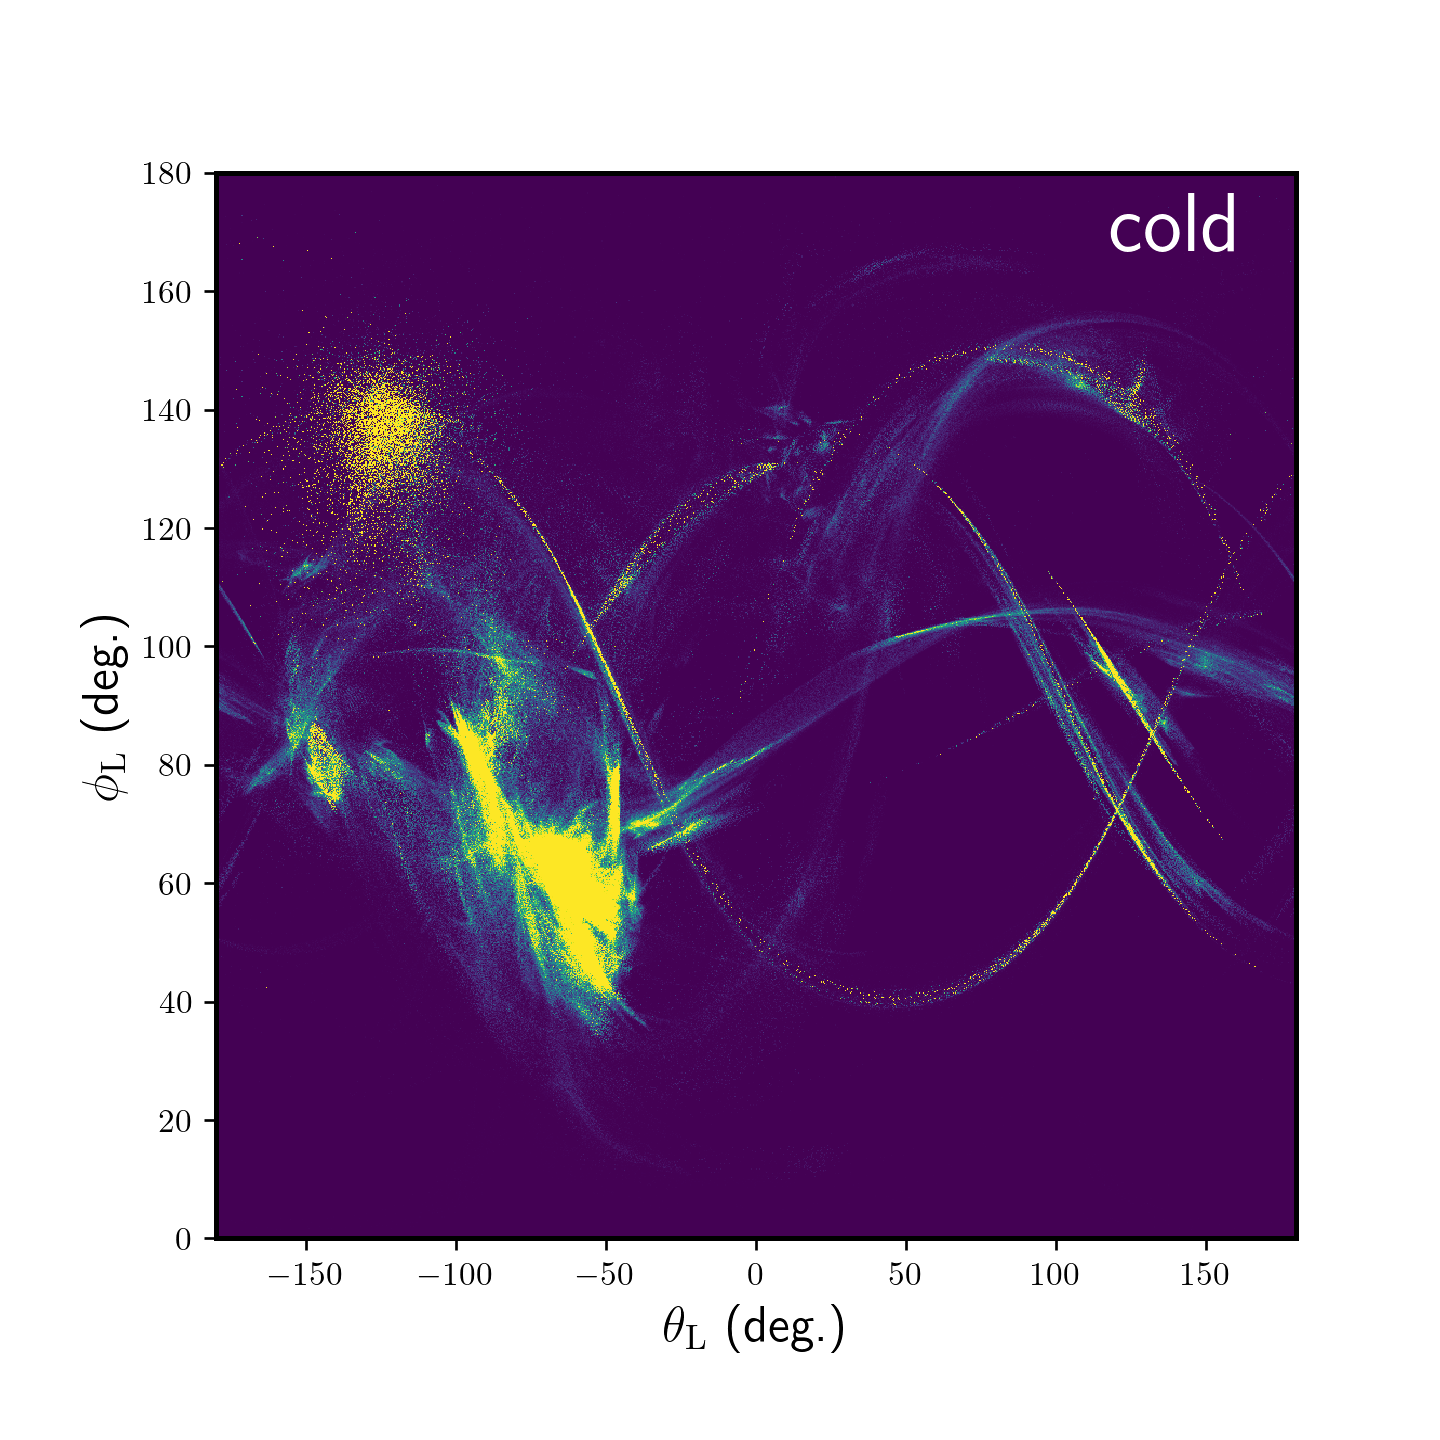

cold


In [44]:
%matplotlib notebook
import numpy as np
L_all = np.load('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/8508/Lprof_8508_RD0027.npy', allow_pickle = True)[()]
import matplotlib.pyplot as plt

# Fixing random state for reproducibility

subplot_kw = dict(xlim=(-180, 180), ylim=(0, 180), autoscale_on=False)
fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize = (6,6))

name_use = 'cold'
for (low_temp, high_temp, name, _) in mass_types:
    if name != name_use: continue
    print (name)
    nbins = 1000
    nbins_select = 100

    xvar, xmn, xmx, xlbl =           L_all[name]['adist']['thel'], -180, 180, r'$\theta_{\mathrm{L}}$ (deg.)'
    yvar, ymn, ymx, ylbl =           L_all[name]['adist']['phil'], 0, 180, r'$\phi_{\mathrm{L}}$ (deg.)'

    weights = L_all[name]['adist']['ltot']
    cmap = plt.cm.viridis
    binsx = np.linspace(xmn, xmx, nbins)
    binsy = np.linspace(ymn, ymx, nbins)

    hst = histogram2d(xvar, yvar, nbins, [[xmn, xmx], [ymn, ymx]], weights = weights)[0]
    vmin, vmax = np.percentile(hst.ravel(), [2, 98])
    ax.hist2d(xvar, yvar, bins = [binsx, binsy], \
              norm = matplotlib.colors.Normalize(vmin, vmax),\
              weights = weights, cmap = cmap)
    ax.annotate(name, (0.95, 0.98), xycoords = 'axes fraction', ha = 'right', va = 'top', \
                color = 'white', fontweight = 'bold', fontsize = 25)

    nx, ny = (30, 30)
    x = np.linspace(-180, 180, nbins_select)
    y = np.linspace(0, 180, nbins_select)
    xv, yv = np.meshgrid(x, y)
    pts = ax.scatter(xv, yv, s=10, alpha = 0.0)
    selector = SelectFromCollection(ax, pts)
    
    
ax.set_ylabel(ylbl)
ax.set_xlabel(xlbl)

fig.subplots_adjust(left = 0.15, bottom = 0.14, hspace = 0.05, wspace = 0.05)




fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")

fig.set_dpi(150)

plt.show()




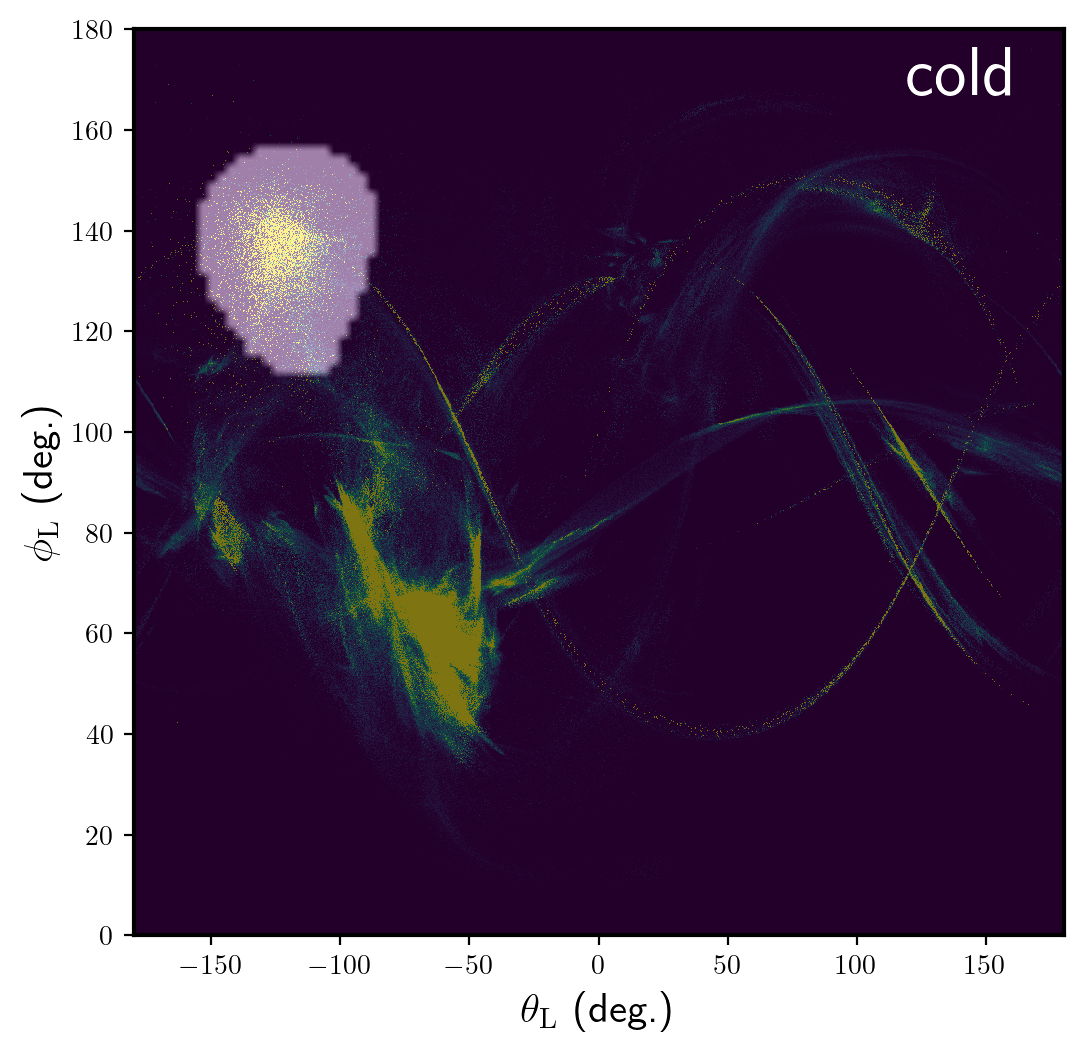

In [45]:
%matplotlib inline
subplot_kw = dict(xlim=(-180, 180), ylim=(0, 180), autoscale_on=False)
fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize = (6,6))
Z2 = np.zeros((nbins_select, nbins_select))
Z2.ravel()[selector.ind] = 1.
extent = -180, 180, 0, 180

ax.hist2d(xvar, yvar, bins = [binsx, binsy], \
          norm = matplotlib.colors.Normalize(vmin, vmax),\
          weights = weights, cmap = cmap, zorder = 1)

ax.imshow(Z2, cmap=plt.cm.Greys_r, alpha=.5, interpolation='bilinear',
                 extent=extent, zorder = 10, aspect = 'auto', origin = 'lower')
ax.annotate(name_use, (0.95, 0.98), xycoords = 'axes fraction', ha = 'right', va = 'top', \
            color = 'white', fontweight = 'bold', fontsize = 25, zorder = 15)

fig.set_dpi(200)
ax.set_ylabel(ylbl)
ax.set_xlabel(xlbl)


plt.show()



yt : [INFO     ] 2021-03-19 12:22:30,916 Projection completed
yt : [INFO     ] 2021-03-19 12:22:30,916 xlim = 34639.611669 34839.611669
yt : [INFO     ] 2021-03-19 12:22:30,917 ylim = 36204.323676 36404.323676
yt : [INFO     ] 2021-03-19 12:22:30,918 xlim = 0.481491 0.484271
yt : [INFO     ] 2021-03-19 12:22:30,918 ylim = 0.503240 0.506020
yt : [INFO     ] 2021-03-19 12:22:30,919 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



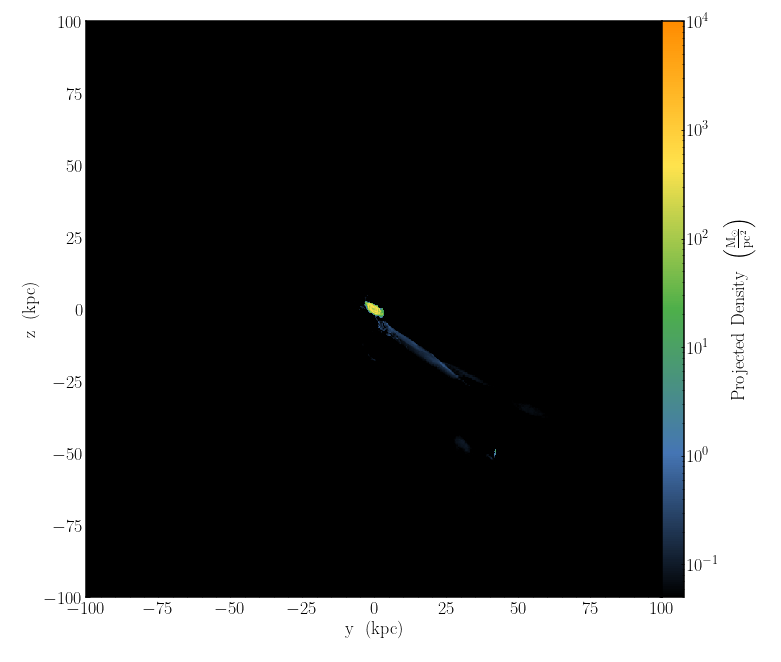

In [42]:
%matplotlib inline
cut_crit = ""
for ii, ind in enumerate(selector.ind):
    low_theta  = xv.ravel()[ind] - 0.5*(360./nbins_select)
    high_theta = xv.ravel()[ind] + 0.5*(360./nbins_select)
    low_phi    = yv.ravel()[ind] - 0.5*(180./nbins_select)
    high_phi   = yv.ravel()[ind] + 0.5*(180./nbins_select)
    if ii > 0: cut_crit = cut_crit + ' | '
    if name_use == 'stars':
        cut_crit = cut_crit + "((obj[('deposit', 'stars_nn_phi_L')] > {}) & (obj[('deposit', 'stars_nn_phi_L')] < {}) & (obj[('deposit', 'stars_nn_theta_L')] > {}) & (obj[('deposit', 'stars_nn_theta_L')] < {}))".format(low_phi, high_phi, low_theta, high_theta)
    else:
        cut_crit = cut_crit + "((obj[('gas', 'phi_L')] > {}) & (obj[('gas', 'phi_L')] < {}) & (obj[('gas', 'theta_L')] > {}) & (obj[('gas', 'theta_L')] < {}))".format(low_phi, high_phi, low_theta, high_theta)

if name_use == 'stars':
    field = ('deposit', 'stars_density')
    cmap =  plt.cm.Greys_r
else:
    cut_crit = cut_crit + " & (obj[('gas', 'temperature')] > {}) & (obj[('gas', 'temperature')] < {})".format(low_temp, high_temp)
    field = ('gas', 'density')
    cmap = density_color_map

    
ptcut = sp_sm.cut_region([cut_crit])
cmap.set_bad('k')
unit = 'Msun/pc**2'
zmin = density_proj_min 
zmax = density_proj_max
weight_field = None


    

prj = yt.ProjectionPlot(ptcut.ds, 'x', field, data_source = ptcut, width = 200*kpc, \
                        weight_field = weight_field, center = ptcut.ds.halo_center_kpc)

prj.set_unit(field, unit)
prj.set_zlim(field, zmin = zmin, zmax =  zmax)
prj.set_cmap(field, cmap)
prj.show()




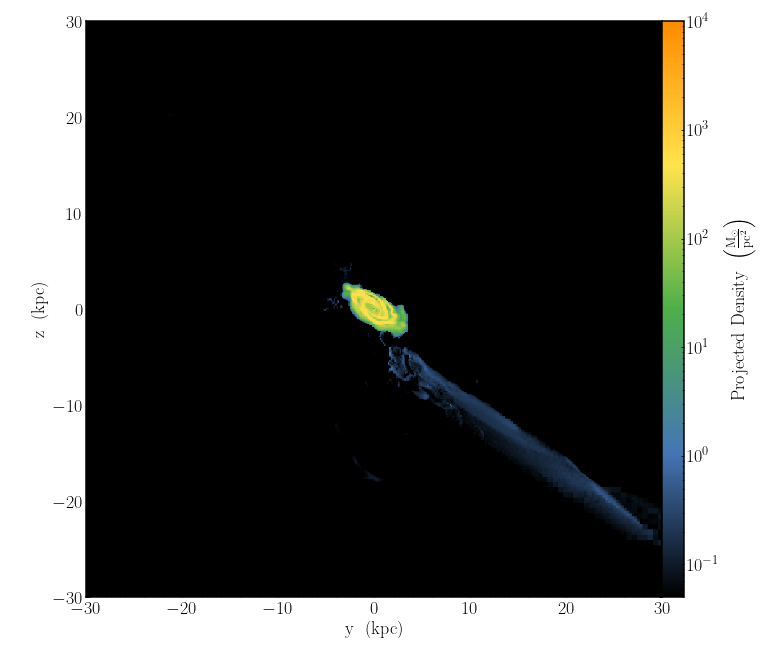

In [43]:
prj.set_width(60*kpc)
prj.show()

In [13]:
selector.ind

array([6213, 6214, 6215, 6216, 6312, 6313, 6314, 6315, 6316, 6317, 6411,
       6412, 6413, 6414, 6415, 6416, 6417, 6510, 6511, 6512, 6513, 6514,
       6515, 6516, 6517, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616,
       6617, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6809,
       6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6909, 6910,
       6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 7008, 7009, 7010,
       7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7108, 7109, 7110,
       7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7209, 7210,
       7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7309, 7310,
       7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7409, 7410,
       7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7509, 7510,
       7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7609, 7610,
       7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7709, 7710,
       7711, 7712, 7713, 7714, 7715, 7716, 7717, 77

In [15]:
ptcut['deposit', 'stars_density']

unyt_array([], dtype=float64, units='g/cm**3')

unyt_array([], dtype=float64, units='g/cm**3')